# Create ambulance service shape files

Turn the LSOA to ambulance service lookup table into shapefiles that can be used for plotting.

## Notebook setup

Packages:

In [1]:
# Import required packages
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import geopandas as gpd

# # Linting
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [ ]:
File locations:

In [6]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    image = './external_images'
    data = './data'
    dir_figures = 'figures'
    dir_ons_geojson = './data/shapefiles/'

    lsoa11_geojson = 'LSOA_Dec_2011_Boundaries_Generalised_Clipped_BGC_EW_V3.geojson'
    ccg15_geojson = 'Clinical_Commissioning_Groups_July_2015_GCB_in_England_2022.geojson'
    ccg21_geojson = 'Clinical_Commissioning_Groups_April_2021_EN_BGC_2022.geojson'
    sicbl22_geojson = 'SICBL_JUL_2022_EN_BGC.geojson'

    lsoa_ambo_results = 'lsoa_ambo_lookup.csv'
    
    ccg15_amb_lookup = 'ccg15_amb.csv'
    sicbl22_amb_lookup = 'sicbl22_amb.csv'
    ccg21_amb_lookup = 'ccg21_amb.csv'

    ambo_name_dict = 'ambulance_service_names.csv'

paths = Paths()

Setup for plots.

Colours for ambulance regions:

In [29]:
# Various seaborn colorblind colours:
c1 = '#0072B2'
c2 = '#009E73'
c3 = '#F0E442'
c4 = '#56B4E9'

# Ambulance service colours:
amb_colour = pd.Series({
    'EEAST': c1,
    'EMAS': c2,
    'IWAS': c1,
    'LAS': c4,
    'NEAS': c2,
    'NWAS': c3,
    'SCAS': c3,
    'SECAmb': c2,
    'SWAS': c2,
    'WMAS': c1,
    'YAS': c1,
    'WAST': c4,
})
amb_colour.name = 'amb_colour'

Labels for ambulance regions:

In [7]:
dict_amb_service_name = pd.read_csv(os.path.join(paths.data, paths.ambo_name_dict), index_col=0).squeeze()

dict_amb_service_name

ambulance_service
EMAS         East Midlands
EEAST      East of England
IWAS         Isle of Wight
LAS                 London
NEAS            North East
NWAS            North West
SCAS         South Central
SECAmb    South East Coast
WMAS         West Midlands
SWAS            South West
WAST                 Welsh
YAS              Yorkshire
Name: ambulance_service_name, dtype: object

Label placement and colours:

In [8]:
df_annotations = pd.DataFrame(
    [
        ['EEAST', 730000, 280000],
        ['EMAS', 620000, 390000],
        ['IWAS', 510000, 70000],
        ['LAS', 650000, 195000],
        ['NEAS', 500000, 580000],
        ['NWAS', 250000, 450000],
        ['SCAS', 380000, 50000],
        ['SECAmb', 670000, 90000],
        ['SWAS', 170000, 160000],
        ['WMAS', 170000, 270000],
        ['YAS', 570000, 490000],
        ['WAST', 200000, 300000],
    ],
    columns=['ambulance_service', 'x_label', 'y_label']
)

# Add full ambulance service name, based on the data dictionary
df_annotations['label'] = (
    df_annotations['ambulance_service'].map(dict_amb_service_name))

# Add colours
df_annotations['amb_colour'] = (
    df_annotations['ambulance_service'].map(amb_colour))

Function to plot the labels:

In [28]:
def plot_annotations(df_annotations):
    for i in range(len(df_annotations)):
        plt.annotate(
            df_annotations.loc[i, 'label'],
            xy=(df_annotations.loc[i, 'x_label'], df_annotations.loc[i, 'y_label']),
            weight='bold',
            bbox=dict(facecolor=df_annotations.loc[i, 'amb_colour']),
            ha='center', va='center'
        )

## Load data

The LSOA-ambulance lookup that we created previously:

In [9]:
lsoa_amb_data = pd.read_csv(os.path.join(paths.data, paths.lsoa_ambo_results))

lsoa_amb_data.head()

,LSOA11NM,LSOA11CD,ambo21,ambo22
0,Adur 001A,E01031349,SECAmb,SECAmb
1,Adur 001B,E01031350,SECAmb,SECAmb
2,Adur 001C,E01031351,SECAmb,SECAmb
3,Adur 001D,E01031352,SECAmb,SECAmb
4,Adur 001E,E01031370,SECAmb,SECAmb


The shapes for all LSOA:

In [10]:
gdf_lsoa = gpd.read_file(os.path.join(paths.dir_ons_geojson, paths.lsoa11_geojson))

gdf_lsoa.head()

,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.097060,51.51810,283b0ead-f8fc-40b6-9a79-1ddd7e5c0758,"POLYGON ((532105.092 182011.231, 532162.491 18..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.091970,51.51868,ddce266b-7825-428c-9e0a-df66b0179a55,"POLYGON ((532634.497 181926.016, 532619.141 18..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.095230,51.52176,c45e358e-a794-485a-bf76-d96e5d458ea4,"POLYGON ((532135.138 182198.131, 532158.250 18..."
3,4,E01000005,City of London 001E,City of London 001E,533581,181265,-0.076280,51.51452,4ddaf5e4-e47f-4312-89a0-923ffec028a6,"POLYGON ((533808.018 180767.774, 533649.037 18..."
4,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,544994,184276,0.089318,51.53876,1c04702a-b662-4cfc-aab9-2c3e0f2d5e29,"POLYGON ((545122.049 184314.931, 545271.849 18..."


## Ambulance service boundaries

Merge the ambulance allocation into the LSOA shapes:

In [11]:
gdf_lsoa = pd.merge(
    gdf_lsoa, lsoa_amb_data.drop('LSOA11NM', axis='columns'),
    on='LSOA11CD', how='left'
)

# Only keep this information:
gdf_lsoa = gdf_lsoa[['geometry', 'ambo21', 'ambo22']]

Create the 2021 and 2022 boundaries separately using the `ambo21` and `ambo22` columns of the LSOA-ambulance lookup.

### 2021 boundaries

Merge LSOA by ambulance service:

In [12]:
gdf_ambo21_lsoa = gdf_lsoa.dissolve(by='ambo21')['geometry']

In [14]:
gdf_ambo21_lsoa

,geometry,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,ambo22,amb_colour
ambo21,,,,,,,,,,,,
EEAST,"MULTIPOLYGON (((504078.594 192959.141, 504011....",15124,E01015589,Peterborough 004A,Peterborough 004A,510040,304962,-0.375540,52.63128,4da3e3bb-97f9-4f95-b211-d7a23ee92eca,EEAST,#0072B2
EMAS,"MULTIPOLYGON (((433452.973 296575.368, 432482....",12729,E01013128,North East Lincolnshire 010A,North East Lincolnshire 010A,530082,408684,-0.037650,53.55868,22b372e4-ba8f-4752-b12f-fe4e54f2da11,EMAS,#009E73
IWAS,"MULTIPOLYGON (((450897.496 75508.595, 450613.3...",16778,E01017282,Isle of Wight 006A,Isle of Wight 006A,458780,90989,-1.168760,50.71555,75c0e1e1-1466-4829-8173-884cceb8ac87,IWAS,#0072B2
LAS,"MULTIPOLYGON (((510797.375 170600.422, 510753....",1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.097060,51.51810,283b0ead-f8fc-40b6-9a79-1ddd7e5c0758,LAS,#56B4E9
NEAS,"MULTIPOLYGON (((417925.732 515867.666, 417905....",7949,E01008162,Gateshead 027A,Gateshead 027A,426408,562669,-1.589150,54.95797,b3e76190-56be-4134-8bf2-6ac07f305224,NEAS,#009E73
NWAS,"MULTIPOLYGON (((326050.501 378570.905, 326038....",4643,E01004766,Bolton 005A,Bolton 005A,371177,411551,-2.437000,53.59974,8b29f815-53d4-4b72-9b25-cf2c22b95fc1,NWAS,#F0E442
SCAS,"MULTIPOLYGON (((431521.123 90539.379, 431498.2...",15779,E01016254,West Berkshire 011A,West Berkshire 011A,459411,164813,-1.147730,51.37926,82b927fc-f1a7-4fe5-9b47-6973a5753472,SCAS,#F0E442
SECAmb,"MULTIPOLYGON (((483647.937 93878.803, 483365.4...",15547,E01016016,Medway 015A,Medway 015A,575802,167303,0.524689,51.37755,d760f752-f29d-4462-95db-2d6f94b132e4,SECAmb,#009E73
SWAS,"MULTIPOLYGON (((83892.297 5351.297, 83908.103 ...",13941,E01014370,Bath and North East Somerset 007A,Bath and North East Somerset 007A,375084,165047,-2.359420,51.38391,4559e288-21f3-4d0d-833c-7a5cb3d48133,SWAS,#009E73


Save results to file:

In [27]:
gdf_ambo21_lsoa.to_file('ambulance_catchment_2021.geojson')

### 2022 boundaries

Merge LSOA by ambulance service:

In [16]:
gdf_ambo22_lsoa = gdf_lsoa.dissolve(by='ambo22')['geometry']

In [18]:
gdf_ambo22_lsoa

,geometry,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,ambo21,amb_colour
ambo22,,,,,,,,,,,,
EEAST,"MULTIPOLYGON (((504078.594 192959.141, 504011....",15124,E01015589,Peterborough 004A,Peterborough 004A,510040,304962,-0.375540,52.63128,4da3e3bb-97f9-4f95-b211-d7a23ee92eca,EEAST,#0072B2
EMAS,"MULTIPOLYGON (((427187.406 311340.906, 427226....",12729,E01013128,North East Lincolnshire 010A,North East Lincolnshire 010A,530082,408684,-0.037650,53.55868,22b372e4-ba8f-4752-b12f-fe4e54f2da11,EMAS,#009E73
IWAS,"MULTIPOLYGON (((450897.496 75508.595, 450613.3...",16778,E01017282,Isle of Wight 006A,Isle of Wight 006A,458780,90989,-1.168760,50.71555,75c0e1e1-1466-4829-8173-884cceb8ac87,IWAS,#0072B2
LAS,"MULTIPOLYGON (((510797.375 170600.422, 510753....",1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.097060,51.51810,283b0ead-f8fc-40b6-9a79-1ddd7e5c0758,LAS,#56B4E9
NEAS,"MULTIPOLYGON (((417925.732 515867.666, 417905....",7949,E01008162,Gateshead 027A,Gateshead 027A,426408,562669,-1.589150,54.95797,b3e76190-56be-4134-8bf2-6ac07f305224,NEAS,#009E73
NWAS,"MULTIPOLYGON (((326050.501 378570.905, 326038....",4643,E01004766,Bolton 005A,Bolton 005A,371177,411551,-2.437000,53.59974,8b29f815-53d4-4b72-9b25-cf2c22b95fc1,NWAS,#F0E442
SCAS,"MULTIPOLYGON (((431521.123 90539.379, 431498.2...",15779,E01016254,West Berkshire 011A,West Berkshire 011A,459411,164813,-1.147730,51.37926,82b927fc-f1a7-4fe5-9b47-6973a5753472,SCAS,#F0E442
SECAmb,"MULTIPOLYGON (((483647.937 93878.803, 483365.4...",15547,E01016016,Medway 015A,Medway 015A,575802,167303,0.524689,51.37755,d760f752-f29d-4462-95db-2d6f94b132e4,SECAmb,#009E73
SWAS,"MULTIPOLYGON (((83892.297 5351.297, 83908.103 ...",13941,E01014370,Bath and North East Somerset 007A,Bath and North East Somerset 007A,375084,165047,-2.359420,51.38391,4559e288-21f3-4d0d-833c-7a5cb3d48133,SWAS,#009E73


Save results to file:

In [27]:
gdf_ambo22_lsoa.to_file('ambulance_catchment_2022.geojson')

## Plot the ambulance region boundaries

Merge colours into the gdf:

In [13]:
gdf_ambo21_lsoa = pd.merge(gdf_ambo21_lsoa, amb_colour, left_index=True, right_index=True, how='left')

In [17]:
gdf_ambo22_lsoa = pd.merge(gdf_ambo22_lsoa, amb_colour, left_index=True, right_index=True, how='left')

Plots:

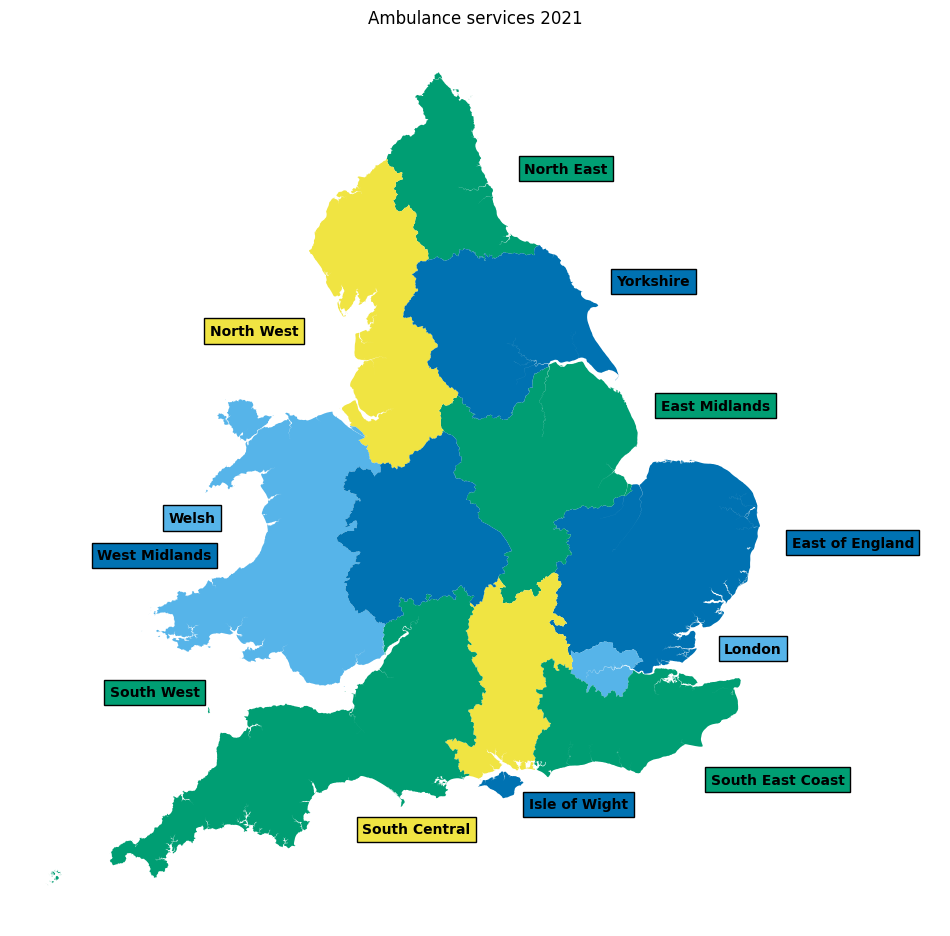

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_ambo21_lsoa.plot(
    ax=ax,
    color=gdf_ambo21_lsoa['amb_colour'],
    edgecolor='none',
)

plot_annotations(df_annotations)

ax.axis('off')
ax.set_xlim(ax.get_xlim()[0], 800000)

ax.set_title('Ambulance services 2021')

plt.savefig(os.path.join(paths.dir_figures, 'ambo_service21.png'), bbox_inches='tight')
plt.show()

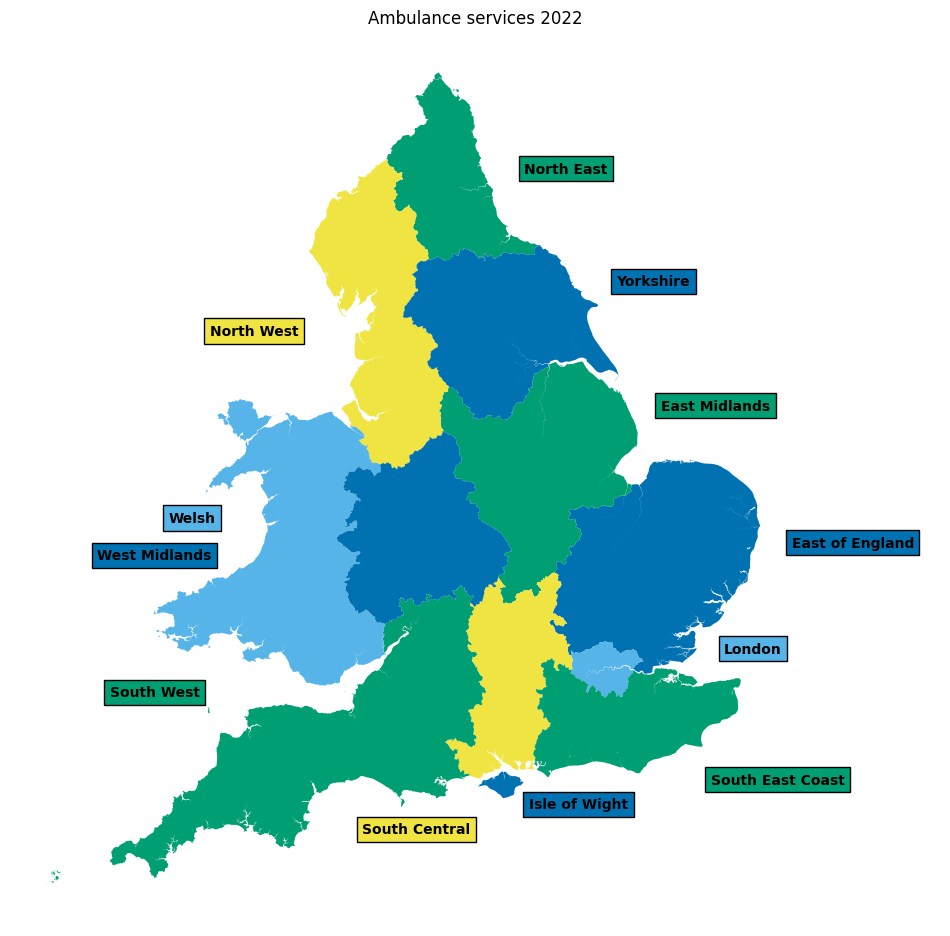

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_ambo22_lsoa.plot(
    ax=ax,
    color=gdf_ambo22_lsoa['amb_colour'],
    edgecolor='none',
)

plot_annotations(df_annotations)

ax.axis('off')
ax.set_xlim(ax.get_xlim()[0], 800000)

ax.set_title('Ambulance services 2022')

plt.savefig(os.path.join(paths.dir_figures, 'ambo_service22.png'), bbox_inches='tight')
plt.show()

## Comparison with health boundaries

### Overlay CCG 2015

In [20]:
# Import CCG 2015 boundaries:
gdf_ccg15 = gpd.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

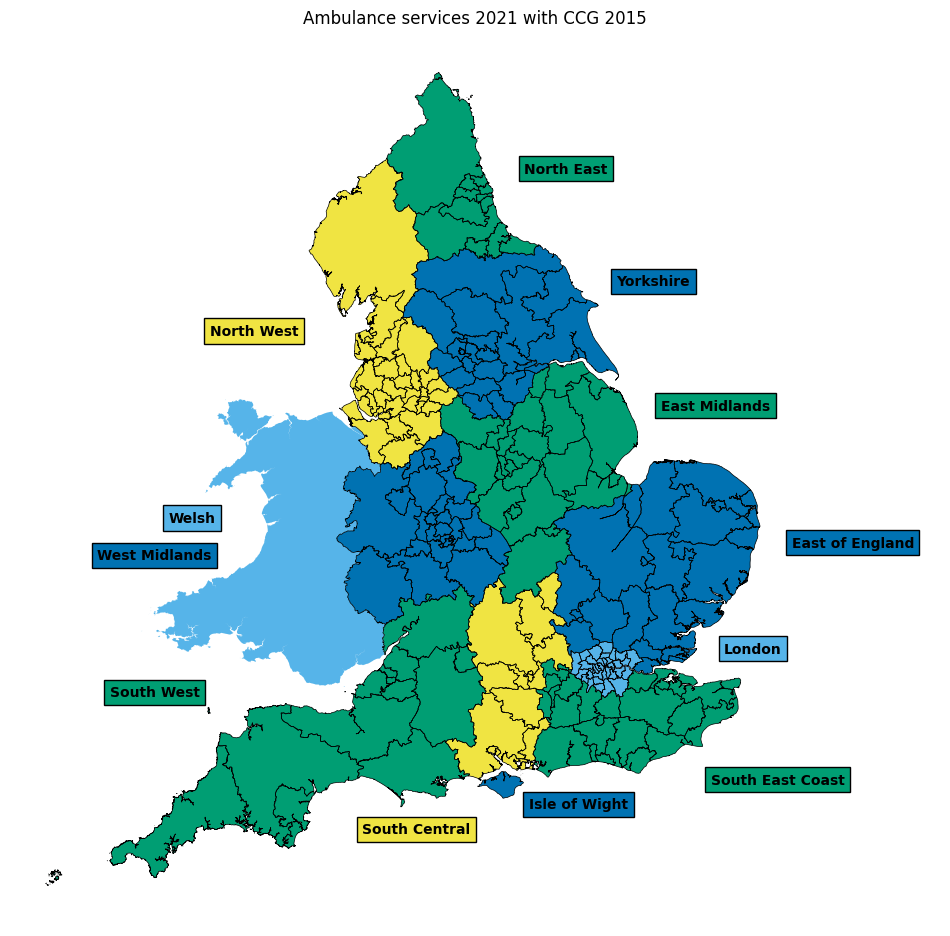

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_ambo21_lsoa.plot(
    ax=ax,
    color=gdf_ambo21_lsoa['amb_colour'],
    edgecolor='none',
)

gdf_ccg15.plot(
    ax=ax,
    color='none',
    edgecolor='k',
    linewidth=0.5,
)

plot_annotations(df_annotations)

ax.axis('off')
ax.set_xlim(ax.get_xlim()[0], 800000)

ax.set_title('Ambulance services 2021 with CCG 2015')

plt.savefig(os.path.join(paths.dir_figures, 'ambo_service21_ccg15.png'), bbox_inches='tight')
plt.show()

### Overlay CCG 2021

In [22]:
# Import CCG 2015 boundaries:
gdf_ccg21 = gpd.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg21_geojson))

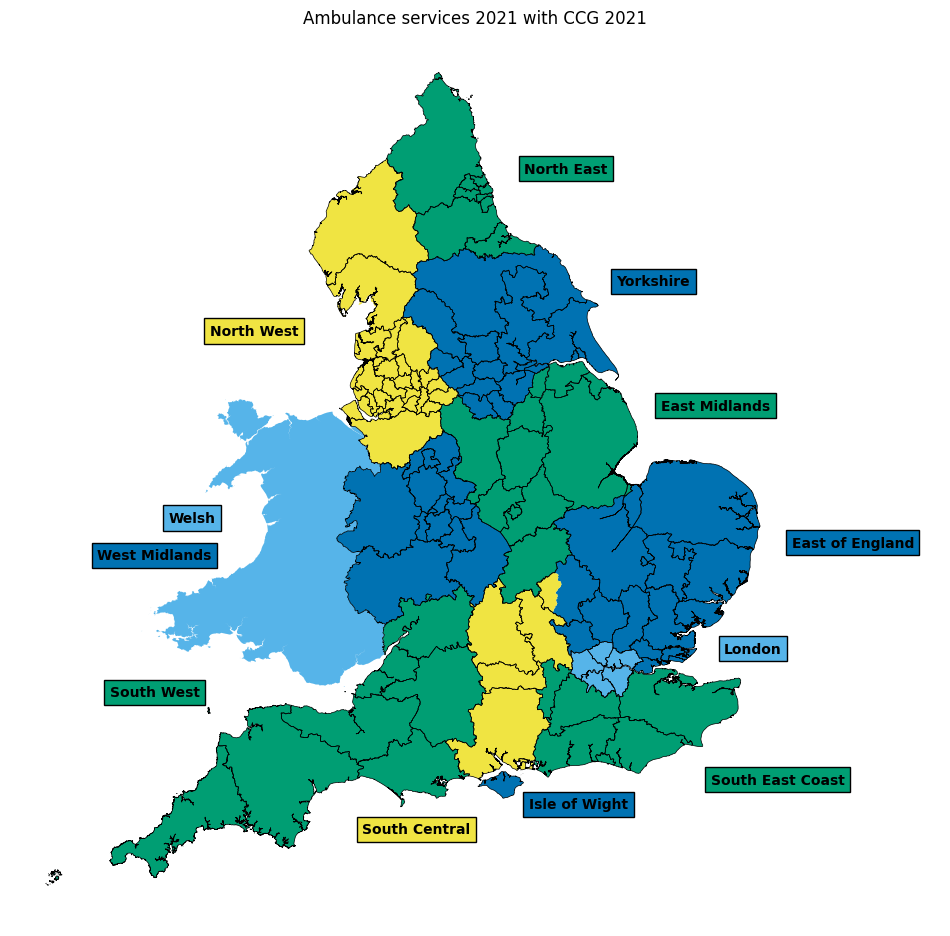

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_ambo21_lsoa.plot(
    ax=ax,
    color=gdf_ambo21_lsoa['amb_colour'],
    edgecolor='none',
)

gdf_ccg21.plot(
    ax=ax,
    color='none',
    edgecolor='k',
    linewidth=0.5,
)

plot_annotations(df_annotations)

ax.axis('off')
ax.set_xlim(ax.get_xlim()[0], 800000)

ax.set_title('Ambulance services 2021 with CCG 2021')

plt.savefig(os.path.join(paths.dir_figures, 'ambo_service21_ccg21.png'), bbox_inches='tight')
plt.show()

### Overlay SICBL 2022

In [24]:
# Import CCG 2015 boundaries:
gdf_sicbl22 = gpd.read_file(os.path.join(paths.dir_ons_geojson, paths.sicbl22_geojson))

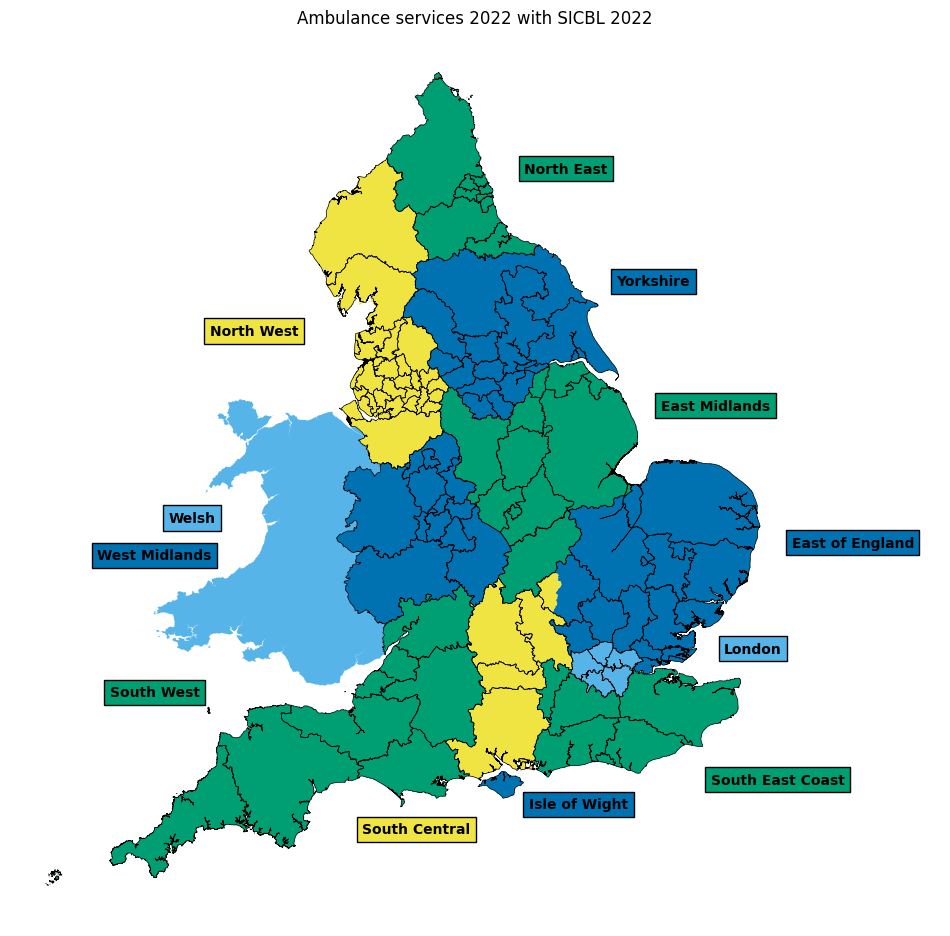

In [25]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_ambo22_lsoa.plot(
    ax=ax,
    color=gdf_ambo22_lsoa['amb_colour'],
    edgecolor='none',
)

gdf_sicbl22.plot(
    ax=ax,
    color='none',
    edgecolor='k',
    linewidth=0.5,
)

plot_annotations(df_annotations)

ax.axis('off')
ax.set_xlim(ax.get_xlim()[0], 800000)

ax.set_title('Ambulance services 2022 with SICBL 2022')

plt.savefig(os.path.join(paths.dir_figures, 'ambo_service22_sicbl22.png'), bbox_inches='tight')
plt.show()